In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spam-mail-dataset/mail_data.csv


# Import Basic Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot  
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings('ignore')

In [6]:
!pip install scikit-learn==1.2.2 imbalanced-learn --upgrade

INFO: pip is looking at multiple versions of imbalanced-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 80.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1,

In [51]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Load Data

In [8]:
data=pd.read_csv('/kaggle/input/spam-mail-dataset/mail_data.csv')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Data Exploration

In [9]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data.tail()

,Category,Message
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [11]:
data.shape

(5572, 2)

In [12]:
data.columns

Index(['Category', 'Message'], dtype='object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [14]:
data.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [15]:
data.nunique()

Category       2
Message     5157
dtype: int64

In [16]:
data.isnull().sum()

Category    0
Message     0
dtype: int64

In [17]:
data.duplicated().sum()

415

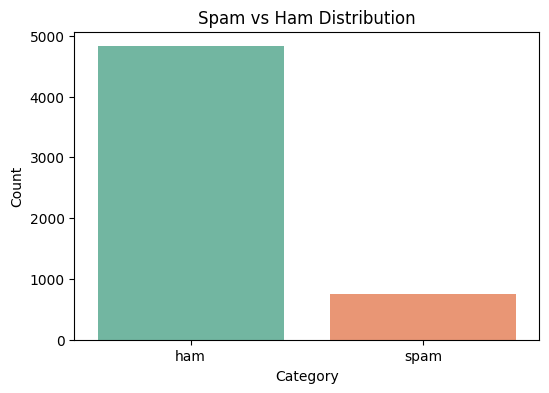

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Category', palette='Set2')
plt.title('Spam vs Ham Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

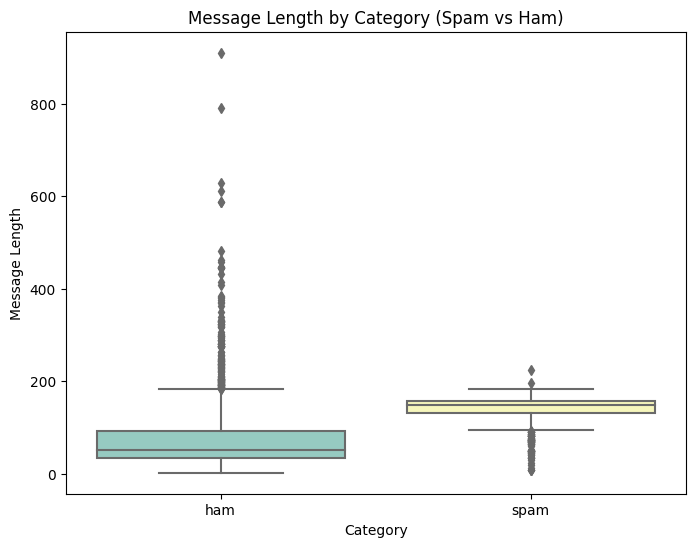

In [19]:
data['Message_Length'] = data['Message'].apply(len)
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Category', y='Message_Length', palette='Set3')
plt.title('Message Length by Category (Spam vs Ham)')
plt.xlabel('Category')
plt.ylabel('Message Length')
plt.show()

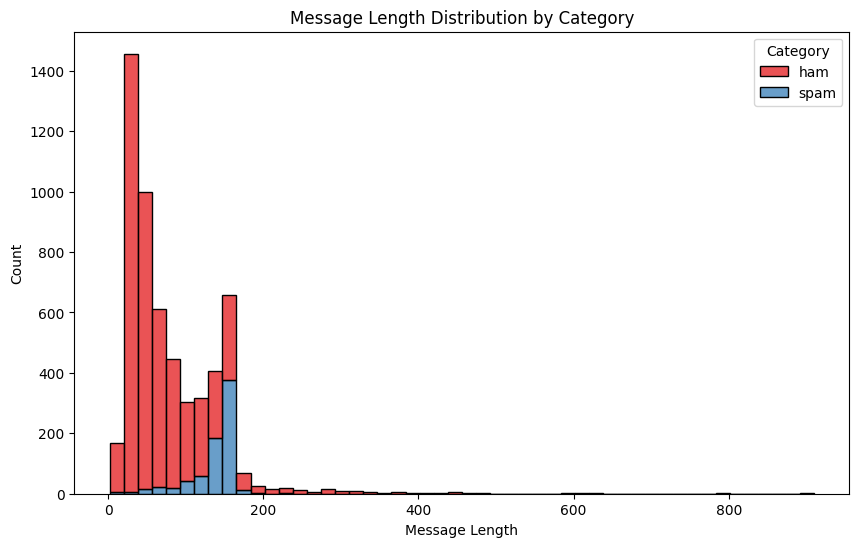

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Message_Length', hue='Category', multiple='stack', palette='Set1', bins=50)
plt.title('Message Length Distribution by Category')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

# Data PreProceesing

In [25]:
data

,Category,Message,Message_Length,Special_Chars_Count,Word_Count,Avg_Word_Length
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,20,4.600000
1,ham,Ok lar... Joking wif u oni...,29,6,6,4.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,28,4.571429
3,ham,U dun say so early hor... U c already then say...,49,6,11,3.545455
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,13,3.769231
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,160,8,30,4.366667
5568,ham,Will ü b going to esplanade fr home?,36,1,8,3.625000
5569,ham,"Pity, * was in mood for that. So...any other s...",57,7,10,4.800000
5570,ham,The guy did some bitching but I acted like i'd...,125,1,26,3.846154


In [26]:
mail_data = data.where((pd.notnull(data)),'') 

In [27]:
mail_data.head()

,Category,Message,Message_Length,Special_Chars_Count,Word_Count,Avg_Word_Length
0,ham,"Go until jurong point, crazy.. Available only ...",111,9,20,4.600000
1,ham,Ok lar... Joking wif u oni...,29,6,6,4.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6,28,4.571429
3,ham,U dun say so early hor... U c already then say...,49,6,11,3.545455
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2,13,3.769231


In [28]:
mail_data.shape

(5572, 6)

# Label Encoding

In [29]:
mail_data.loc[mail_data['Category'] == 'spam', 'Category',] = 0
mail_data.loc[mail_data['Category'] == 'ham', 'Category',] = 1

In [30]:
X = mail_data['Message']
Y = mail_data['Category']

In [31]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ü b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: Message, Length: 5572, dtype: object

In [32]:
Y

0       1
1       1
2       0
3       1
4       1
       ..
5567    0
5568    1
5569    1
5570    1
5571    1
Name: Category, Length: 5572, dtype: object

In [33]:
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_vectorized, Y, test_size=0.2, random_state=42, stratify=Y)

print("Before SMOTE:", Counter(Y_train))

Before SMOTE: Counter({1: 3859, 0: 598})


In [40]:
Y_train = Y_train.astype('int')

In [42]:
!pip install --upgrade threadpoolctl

In [43]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

print("After SMOTE:", Counter(Y_train_resampled))

After SMOTE: Counter({1: 3859, 0: 3859})


# Model Creation

In [ ]:
Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

## Random Forest

In [46]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, Y_train_resampled)

RandomForestClassifier(random_state=42)

In [52]:
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
rmse = mean_squared_error(Y_test, y_pred, squared=False)
mae = mean_absolute_error(Y_test, y_pred)
r2  = r2_score(Y_test, y_pred)

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

MSE:  0.0251
RMSE: 0.1585
MAE:  0.0251
R²:   0.7831


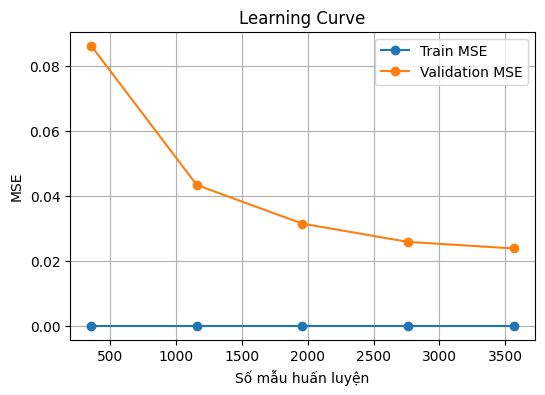

In [58]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, Y_train,
    cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42)

train_mse = -train_scores.mean(axis=1)
val_mse   = -val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mse, 'o-', label="Train MSE")
plt.plot(train_sizes, val_mse,   'o-', label="Validation MSE")
plt.xlabel("Số mẫu huấn luyện")
plt.ylabel("MSE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()